In [2]:
from tqdm import tqdm
from py import nets, utils
from py.train import train_with_validation
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim, LongTensor
from py.train import train_mnist, train_with_validation, cifar_calc_fps
from torch.utils.data.sampler import SubsetRandomSampler
from py.nets import CIFARModel
from py.datasets import CIFAR10P
from algo.variable_optim import VSGD
import numpy as np
import torch

PERTURBATIONS = [
    "brightness",
    "gaussian_blur",
    "gaussian_noise",
    "gaussian_noise_2",
    "gaussian_noise_3",
    "motion_blur",
    "rotate",
    "scale",
    "shear",
    "shot_noise",
    "shot_noise_2",
    "shot_noise_3",
    "snow",
    "spatter",
    "speckle_noise",
    "speckle_noise_2",
    "speckle_noise_3",
    "tilt",
    "translate",
    "zoom_blur"
]

import os
from py.utils import download_url

url = "https://zenodo.org/record/2535967/files/CIFAR-10-P.tar"
target_path = './datasets/CIFAR-10-P-tar'

import tarfile

# WARNING: 15 GB DOWNLOAD

In [29]:
# Download the data

if (os.path.exists("./datasets/CIFAR-10-P/") != True):
    download_url(url, target_path)
    with tarfile.open(target_path) as tar:
        tar.extractall(path="./datasets")
    os.remove(target_path)

# Plot example images

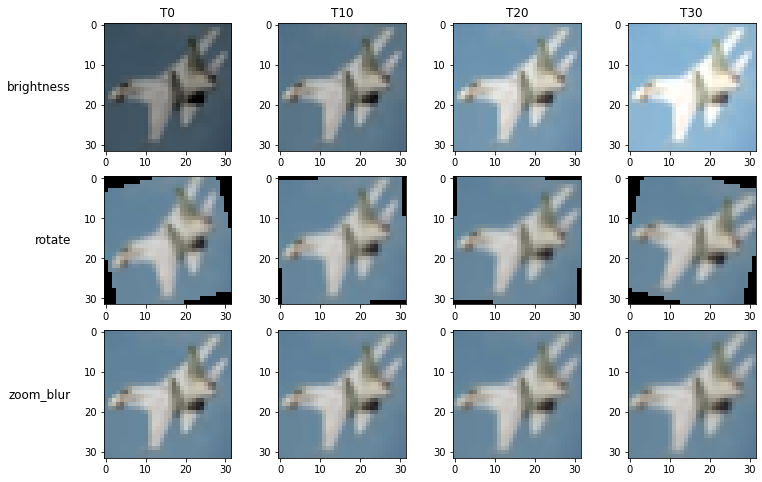

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
%matplotlib inline

perturbations = ["brightness", "rotate", "zoom_blur"]

import matplotlib.pyplot as plt

nrows=3
ncols=4

cols = ['{}'.format(col) for col in ["T0", "T10", "T20", "T30"]]
rows = ['{}'.format(row) for row in perturbations]
        
    
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
plt.setp(axes.flat, xlabel='', ylabel='')

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    
pad = 5

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
j = 0    
for p in perturbations:
    data = np.load("./datasets/CIFAR-10-P/" + p + ".npy")
    for i in range(0, 31, 10):
        ax = axes[j][i//10]
        ax.imshow(data[10][i])
        #ax.axis("off")
        #axes[i//10][j].imshow(img)
    j = j + 1
        
#fig.tight_layout()
plt.savefig('./plots/cifar10p.png', dpi=300, bbox_inches='tight')
plt.show()

# Prepare train and validation loaders

In [4]:
MEAN = [0.49139968, 0.48215841, 0.44653091]
STD  = [0.24703223, 0.24348513, 0.26158784]

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

n_epochs = 15
batch_size = 64
learning_rate = 0.01
momentum = 0.9
num_workers=4

# Proportion of training set to use as validation
validation_size = 0.2

train_data = datasets.CIFAR10('./datasets', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('./datasets', train=False, download=True, transform=transform)

# Obtain training indexs that will be used for training and validation loaders
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare dataloaders with train and valid samplers
train_loader = DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Set up base and VSGD model

In [22]:
base_model = nets.CIFARModel()

device = utils.get_default_device()
base_model.load_state_dict(torch.load("./models/cifar_model.pt"))
base_model.to(device)

vsgd_model = nets.CIFARModel()

vsgd_model.to(device)

CIFARModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Get Flip Probabilities for Base

In [24]:
fps = {}

import pprint
base_flip_probabilities = cifar_calc_fps(base_model, PERTURBATIONS, device)
pprint.pprint(base_flip_probabilities)
fps['base'] = base_flip_probabilities
mean_base_flip_rate = np.mean(list(base_flip_probabilities.values()))
print(f"Base mean flip rate: {mean_base_flip_rate}") 

  0%|          | 0/20 [00:00<?, ?it/s]

{'brightness': 0.6311866666666667,
 'gaussian_blur': 0.6242466666666666,
 'gaussian_noise': 0.62816,
 'gaussian_noise_2': 0.634,
 'gaussian_noise_3': 0.6412233333333334,
 'motion_blur': 0.609115,
 'rotate': 0.6865833333333333,
 'scale': 0.67828,
 'shear': 0.6912266666666667,
 'shot_noise': 0.6320033333333334,
 'shot_noise_2': 0.6349566666666666,
 'shot_noise_3': 0.6348133333333333,
 'snow': 0.6282166666666666,
 'spatter': 0.6335766666666667,
 'speckle_noise': 0.6307666666666667,
 'speckle_noise_2': 0.6350533333333334,
 'speckle_noise_3': 0.6352266666666667,
 'tilt': 0.6597866666666666,
 'translate': 0.6812266666666666,
 'zoom_blur': 0.62516}
Base mean flip rate: 0.6427404166666667


# Get Flip Probabilities for VSGD model at different variabilities

In [26]:
var_file_names = ["1.0e-01", "1.0e-02", "1.5e-03", "2.0e-03", "5.0e-03"]

for var_file in var_file_names:
    print(float(var_file))
    vsgd_model.load_state_dict(torch.load(f"./models/vsgd_cifar_{var_file}.pt"))
    vsgd_flip_probabilities = cifar_calc_fps(vsgd_model, PERTURBATIONS, device)
    fps[f"vsgd {float(var_file)}"] = vsgd_flip_probabilities
    mean_vsgd_flip_rate = np.mean(list(vsgd_flip_probabilities.values()))
    print(f"Mean VSGD flip rate: {mean_vsgd_flip_rate}") 

0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Mean VSGD flip rate: 0.6296655833333333
0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Mean VSGD flip rate: 0.6153332499999999
0.0015


  0%|          | 0/20 [00:00<?, ?it/s]

Mean VSGD flip rate: 0.6190068333333333
0.002


  0%|          | 0/20 [00:00<?, ?it/s]

Mean VSGD flip rate: 0.6478556666666667
0.005


  0%|          | 0/20 [00:00<?, ?it/s]

Mean VSGD flip rate: 0.6656107499999999


# Plot bar graph of Flip Probabilities

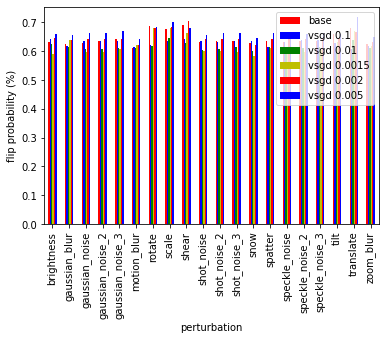

In [27]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd


ax = pd.DataFrame(fps).plot(kind='bar', color=['r', 'b', 'g', 'y'])
plt.ylabel('flip probability (%)')
plt.xlabel('perturbation')
plt.savefig('./plots/cifar_perturbation_fps.png', dpi=300, bbox_inches='tight')

plt.show()